# PoC predicting force from RMS
#

In [3]:
import os
import numpy as np
import pandas as pd
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Function to compute RMS of numeric data in a file (CSV, TXT, or MATLAB .mat)
def compute_rms(file_path):
    ext = os.path.splitext(file_path)[1].lower()
    # Handle MATLAB .mat files
    if ext == '.mat':
        mat_data = scipy.io.loadmat(file_path)
        # Filter out metadata keys
        arrays = [v for k, v in mat_data.items() if not k.startswith('__')]
        if not arrays:
            raise RuntimeError(f"No numeric arrays found in {file_path}")
        # Use the first array found
        data = np.array(arrays[0])
    else:
        # Load numeric data; adjust delimiter if needed
        try:
            data = np.loadtxt(file_path, delimiter=',')
        except Exception:
            data = np.loadtxt(file_path)
    # Determine the values vector
    if data.ndim == 1:
        values = data
    elif data.ndim > 1:
        # assume measurement in second column
        values = data[:, 1]
    else:
        raise RuntimeError(f"Unsupported data dimensions in {file_path}")
    # Compute RMS
    return np.sqrt(np.mean(values**2))

# Path to your samples folder (e.g., contains F1_xxx.mat, F2_xxx.mat)
samples_folder = "samples"

data = []
for fname in os.listdir(samples_folder):
    ext = os.path.splitext(fname)[1].lower()
    if ext in ('.csv', '.txt', '.mat'):
        path = os.path.join(samples_folder, fname)
        rms_val = compute_rms(path)
        # Extract class label from filename (F1 or F2)
        key = fname.upper()
        if 'F1' in key:
            label = 'F1'
        elif 'F2' in key:
            label = 'F2'
        else:
            # Skip files without F1/F2 in name
            continue
        data.append({'file': fname, 'rms': rms_val, 'label': label})

# Create DataFrame
if not data:
    raise RuntimeError("No valid sample files found in 'samples' folder.")

df = pd.DataFrame(data)
df['label_enc'] = df['label'].map({'F1': 0, 'F2': 1})

# Features and target
X = df[['rms']].values
y = df['label_enc'].values

# Split into train/test sets
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

# Train a simple logistic regression classifier
model = LogisticRegression()
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluation
print(f"Test set size: {len(X_test)} samples")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred, target_names=['F1', 'F2']))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Display the DataFrame of RMS values and labels
print("\nSamples and RMS values:\n", df)

Test set size: 3 samples
Accuracy: 0.6666666666666666
Classification Report:
               precision    recall  f1-score   support

          F1       0.67      1.00      0.80         2
          F2       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3

Confusion Matrix:
 [[2 0]
 [1 0]]

Samples and RMS values:
                                                  file       rms label  \
0   P3_90Deg_F1_1_plateau_iAll_MUedit.mat_decomp_7...  0.012132    F1   
1   P3_90Deg_F1_1_plateau_iAll_MUedit.mat_decomp_7...  0.048417    F1   
2   P1_90Deg_F1_1_plateau_iAll_MUedit.mat_decomp_1...  0.046216    F1   
3   P1_90Deg_F1_1_plateau_iAll_MUedit.mat_decomp_1...  0.034405    F1   
4   P1_180Deg_F1_1_plateau_iAll_MUedit.mat_decomp_...  0.021734    F1   
5   P1_180Deg_F1_1_plateau_iAll_MUedit.mat_decomp_...  0.027483    F1   
6   P1_180Deg_F1_2_plate

/Users/juliahagen/Library/Caches/pypoetry/virtualenvs/fd-intraeeg-SfzCdUtK-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliahagen/Library/Caches/pypoetry/virtualenvs/fd-intraeeg-SfzCdUtK-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/juliahagen/Library/Caches/pypoetry/virtualenvs/fd-intraeeg-SfzCdUtK-py3.10/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set t


Label Distribution:
 label
F1    10
F2     2
Name: count, dtype: int64

RMS Statistics:
 count    12.000000
mean      0.035965
std       0.018427
min       0.008405
25%       0.020743
50%       0.037488
75%       0.049745
max       0.062824
Name: rms, dtype: float64


<Axes: title={'center': 'RMS Distribution'}, xlabel='RMS', ylabel='Frequency'>

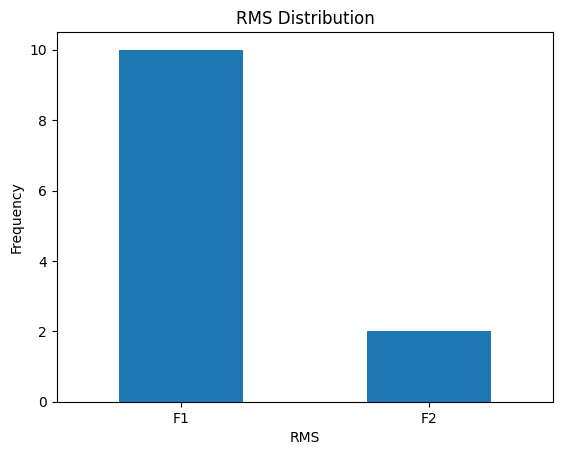

In [6]:

# Distribution of labels
label_counts = df['label'].value_counts()
print("\nLabel Distribution:\n", label_counts)

# Plot label distribution
label_counts.plot(kind='bar', title='Label Distribution', xlabel='Label', ylabel='Count')

# Distribution of RMS
rms_stats = df['rms'].describe()
print("\nRMS Statistics:\n", rms_stats)

# Plot RMS distribution
df['rms'].plot(kind='hist', bins=10, title='RMS Distribution', xlabel='RMS', ylabel='Frequency')